# Notebook to try detrending emg data

## Imports

In [1]:
import os 
import pickle
import pywt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal

from mosquito.util import idx_by_thresh, butter_highpass_filter, moving_avg
from mosquito.process_abf import load_processed_data

## Params

In [2]:
plt.style.use('dark_background')
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels

## Load data

In [9]:
# info for data
data_folder = '19_20240510' # '22_20240516'  # '17_20240507' # '05_20240322' 
axo_num = 0

data = load_processed_data(data_folder, axo_num)


In [10]:
# read out data 
t = data['time']  
emg_filt = data['emg_filt']
emg = data['emg']
spike_idx = data['spike_idx']
mic_phase = data['mic_phase'] 
mic_filt = data['mic_filt']
wbf = data['wbf'] 

window = round(data['params']['emg_window']/2)
fs = data['sampling_freq']


## Moving average detrend

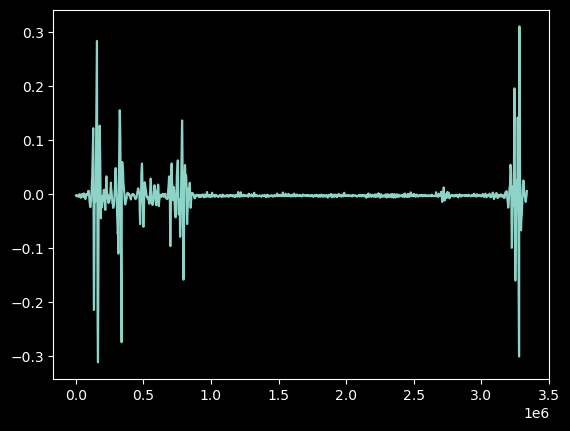

In [11]:
# get the moving average
emg_curr = emg_filt
emg_df = pd.Series(emg_curr)
window_size = 4095
emg_moving_avg = emg_df.rolling(window=window_size, center=True).median()
plt.plot(emg_moving_avg)

In [12]:
emg_rolling_median = emg_df.rolling(window=window_size, center=True).median()
test = emg_curr - emg_rolling_median
emg_rolling_median

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
           ..
3338491   NaN
3338492   NaN
3338493   NaN
3338494   NaN
3338495   NaN
Length: 3338496, dtype: float64

(0.0, 25.0)

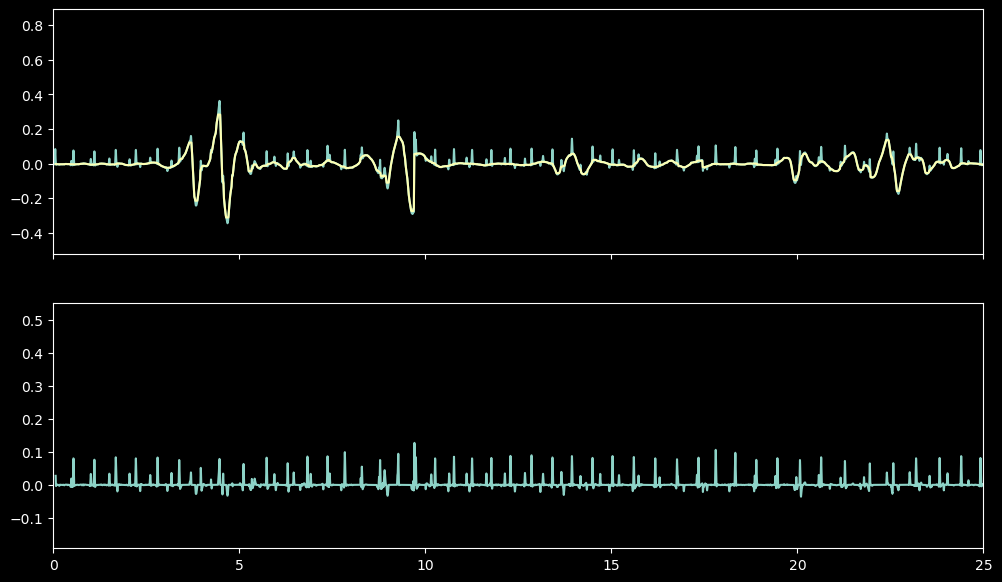

In [13]:
# visualize data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,7), sharex=True)

ax1.plot(t, emg_curr)
ax1.plot(t, emg_moving_avg)

ax2.plot(t, emg_curr - emg_moving_avg)

ax1.set_xlim([0, 25])
# ax1.set_xlim([0, 5])
# ax1.set_ylim([1, 1.75])

In [8]:
# what is the window size in seconds?
window_size_dt = (1/fs)*window_size
1/window_size_dt

7.0174

## Try wavelet approach

In [15]:
# some helper functions from EAT code
#------------------------------------------------------------------------------
def wcoef_plot(coeffs):
    """
    adapted: http://jseabold.net/blog/2012/02/23/wavelet-regression-in-python/
    
    """
    n_levels = len(coeffs)
    fig, ax_arr = plt.subplots(n_levels) 

    for i in range(n_levels):
        ax_arr[i].stem(coeffs[i])

    return fig
#------------------------------------------------------------------------------
def wcoeff_sparsity_metric(coeffs):
    wlevel_max = len(coeffs)-1
    spars_met = np.zeros((wlevel_max,1))
    for wl in np.arange(1,wlevel_max+1):
        spars_met[wl-1] = np.max(np.abs(coeffs[wl]))/np.sum(np.abs(coeffs[wl]))  
        #spars_met[wl-1] = np.sum(np.abs(coeffs[wl]))/np.sqrt(np.sum(coeffs[wl]**2))  
    #spars_met = np.flipud(spars_met)
    return spars_met 

#------------------------------------------------------------------------------
def wavelet_denoise(data,wtype='db4',wlevel=2,s_thresh=0.1, plotFlag=False):
    #s_thresh=0.08
    coeffs = pywt.wavedec(np.squeeze(data),wtype, level=wlevel,mode='symmetric')
    
    if plotFlag:
        wcoef_plot(coeffs)
        
    # find wavelet level based on sparsity metric
    sparsity_metric = wcoeff_sparsity_metric(coeffs)
    #print('sparsity metric = {}'.format(sparsity_metric))
    while (np.max(sparsity_metric) > s_thresh) and (wlevel > 2):
        wlevel = wlevel - 1 
        coeffs = pywt.wavedec(np.squeeze(data),wtype,level=wlevel,mode='symmetric')
        sparsity_metric = wcoeff_sparsity_metric(coeffs)
        #print('sparsity metric = {}'.format(sparsity_metric))
        
    sigma = mad(coeffs[-1])
    uthresh = sigma*np.sqrt(2*np.log(data.size))

    denoised = coeffs[:]
    denoised[1:] = ( pywt.threshold(i, value=uthresh, mode='soft') for i in denoised[1:])
    
    data_denoised = pywt.waverec(denoised, wtype,mode='symmetric')
    
    if plotFlag:
        plt.figure()
        plt.plot(data)
        plt.plot(data_denoised,'r')
        plt.tight_layout()
        print('wlevel = {}'.format(wlevel))
        
    if (data.size != data_denoised.size):
        data_denoised = data_denoised[0:data.size]
        
    #print(wlevel)
    return data_denoised

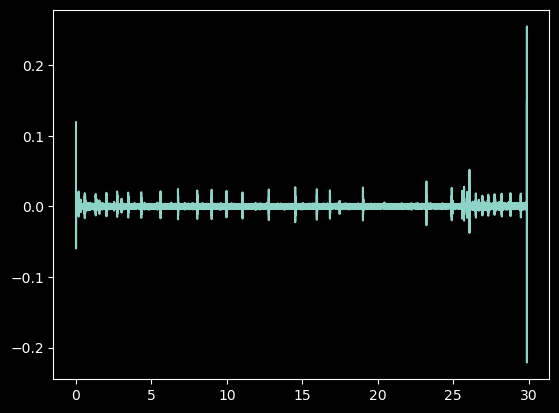

In [90]:
# decompose signal 
level=5
ind_curr = slice(2**20)
# coeffs = pywt.mra(emg, wavelet='sym4', level=level)
coeffs = pywt.swt(emg[ind_curr], wavelet='sym4', level=level, norm=True, trim_approx=False)
# ca = coeffs[0]
# details = coeffs[1:]

fig, ax = plt.subplots()
# ax.plot(t[ind_curr], emg[ind_curr])
ax.plot(t[ind_curr], coeffs[0][1])

# ax.set_xlim([0, 5])
# ax.set_ylim([-0.1, 0.1])

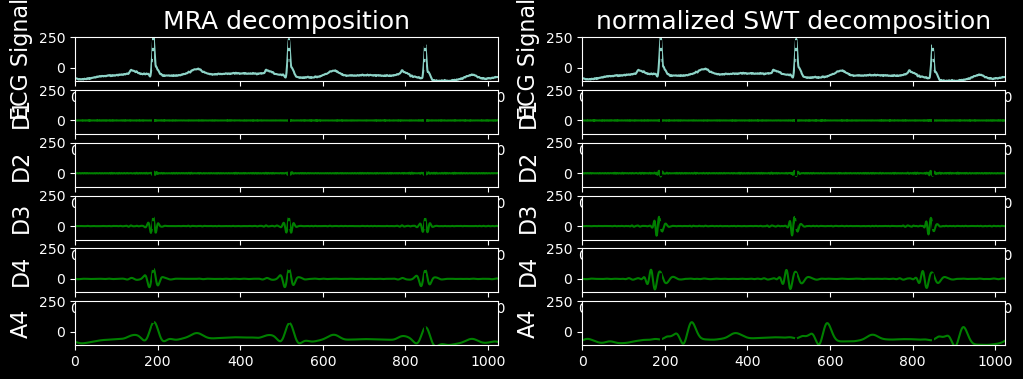

In [16]:
# import pywt.data

# ecg = pywt.data.ecg()

# wavelet = pywt.Wavelet('db8')  #'db16')
# level = 4
# coeffs = pywt.mra(ecg, wavelet=wavelet, level=level)
# ca = coeffs[0]
# details = coeffs[1:]

# # Create a plot using the same axis limits for all coefficient arrays to
# # illustrate the preservation of alignment across decomposition levels.
# ylim = [ecg.min(), ecg.max()]

# def mark_peaks(ax):
#     # add dashed lines at the locations of the ECG peaks for reference
#     ylim = ax.get_ylim()
#     ax.plot([190, 190], ylim, 'k--')
#     ax.plot([518, 518], ylim, 'k--')
#     ax.plot([848, 848], ylim, 'k--')

# fig, axes = plt.subplots(len(coeffs) + 1, 2, figsize=[12, 4])
# axes[0][0].set_title("MRA decomposition")
# axes[0][0].plot(ecg)
# axes[0][0].set_ylabel('ECG Signal')
# axes[0][0].set_xlim(0, len(ecg) - 1)
# axes[0][0].set_ylim(ylim[0], ylim[1])
# mark_peaks(axes[0][0])

# for i, x in enumerate(coeffs):
#     ax = axes[-i - 1][0]
#     ax.plot(coeffs[i], 'g')
#     if i == 0:
#         ax.set_ylabel("A%d" % (len(coeffs) - 1))
#     else:
#         ax.set_ylabel("D%d" % (len(coeffs) - i))
#     # Scale axes
#     ax.set_xlim(0, len(ecg) - 1)
#     ax.set_ylim(ylim[0], ylim[1])
#     mark_peaks(ax)

# """
# repeat using the SWT instead of MRA as the decomposition
# """
# coeffs = pywt.swt(ecg, wavelet=wavelet, level=level, norm=True, trim_approx=True)
# ca = coeffs[0]
# details = coeffs[1:]

# axes[0][1].set_title("normalized SWT decomposition")
# axes[0][1].plot(ecg)
# axes[0][1].set_ylabel('ECG Signal')
# axes[0][1].set_xlim(0, len(ecg) - 1)
# axes[0][1].set_ylim(ylim[0], ylim[1])
# mark_peaks(axes[0][1])

# for i, x in enumerate(coeffs):
#     ax = axes[-i - 1][1]
#     ax.plot(coeffs[i], 'g')
#     if i == 0:
#         ax.set_ylabel("A%d" % (len(coeffs) - 1))
#     else:
#         ax.set_ylabel("D%d" % (len(coeffs) - i))
#     # Scale axes
#     ax.set_xlim(0, len(ecg) - 1)
#     ax.set_ylim(ylim[0], ylim[1])
#     mark_peaks(ax)